In [ ]:
import os
from glob import glob
import numpy as np
import pandas as pd
import xarray as xr
import dask
import gev_utils as gevu
import gev_nonstat_utils as gevns
import sa_utils as sau
import plotting_utils as pu

from utils import city_list
from utils import roar_code_path as project_code_path
from utils import roar_data_path as project_data_path
from utils import gev_metric_ids, gard_gcms

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:
# Set fonts
from matplotlib import font_manager
font_dirs = ["/storage/home/dcl5300/fonts"]

font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.5

In [ ]:
# ############
# ### Dask ###
# ############
# from dask_jobqueue import SLURMCluster

# cluster = SLURMCluster(
#     account="pches_cr_default",
#     queue='basic',
#     cores=1,
#     processes=1,
#     memory="100GiB",
#     walltime="00:20:00",
# )

# cluster.scale(jobs=1)  # ask for jobs

# from dask.distributed import Client
# client = Client(cluster)
# client

### Preliminaries

In [ ]:
def plot_uc_single_metric(metric_id, hist_slice, title, save_path, vmax_uc=30):
    """
    Plots all return level UC maps for a single metric.
    """
    fig = plt.figure(figsize=(12, 11), layout='constrained')
    subfigs = fig.subfigures(4, 1, hspace=0.03)

    for idp, return_period in enumerate([10,25,50,100]):
        # Get info
        axs = subfigs[idp].subplots(1, 6, subplot_kw=dict(projection=ccrs.LambertConformal()))
        plot_col = f"{return_period}yr_return_level"
        subfig_title = f"{return_period}-year return level"
        # Plot
        pu.plot_uc_map(
            metric_id=metric_id,
            proj_slice="2050-2100",
            hist_slice=hist_slice,
            plot_col=plot_col,
            return_period=return_period,
            grid="LOCA2",
            fit_method="lmom",
            stationary=True,
            analysis_type="extreme_value",
            regrid_method="nearest",
            norm="uc_99w",
            vmax_uc=vmax_uc,
            fig=subfigs[idp],
            axs=axs,
            title=subfig_title,
        )
    fig.suptitle(title, fontweight="bold")
    if save_path is not None:
        plt.savefig(f'../figs/{save_path}.png', dpi=300)
    else:
        plt.show()

## Analysis

In [14]:
# Non-stationary bootstrap, absolute projections
grid = "LOCA2"
regrid_method = "nearest"
proj_slice = "1950-2100"
hist_slice = None
return_levels = [10,25,50,100]
fit_method = "mle"
stationary = False
stat_str = "stat" if stationary else "nonstat"

_preprocess_func = lambda x: x.sel(time=2075)
time_name = '2075'

# Loop through metrics
for metric_id in gev_metric_ids[:3]:
    # Loop through return levels
    for return_level in return_levels:
        # Check if done
        col_name = f"{return_level}yr_return_level"
        save_path = f"{project_data_path}/results/{metric_id}_{proj_slice}_{col_name}_{time_name}_{fit_method}_{stat_str}_{grid}grid_{regrid_method}.nc"
        # Calculate
        if not os.path.exists(save_path):
            uc = sau.uc_all(metric_id=metric_id,
                            grid=grid,
                            fit_method=fit_method,
                            stationary=stationary,
                            regrid_method=regrid_method,
                            proj_slice=proj_slice,
                            hist_slice=hist_slice,
                            col_name_main=col_name,
                            col_name_boot=col_name,
                            include_fit_uc=True,
                            _preprocess_func_boot=_preprocess_func,
                            _preprocess_func_main=_preprocess_func,
                           )
            # Store
            uc.to_netcdf(save_path)
            print(f"Done: {save_path.split('/')[-1]}")
            del uc # memory management
        else:
            print(f"Already done: {save_path.split('/')[-1]}")

Already done: max_tasmax_1950-2100_10yr_return_level_2075_mle_nonstat_LOCA2grid_nearest.nc
Already done: max_tasmax_1950-2100_25yr_return_level_2075_mle_nonstat_LOCA2grid_nearest.nc
Already done: max_tasmax_1950-2100_50yr_return_level_2075_mle_nonstat_LOCA2grid_nearest.nc
Already done: max_tasmax_1950-2100_100yr_return_level_2075_mle_nonstat_LOCA2grid_nearest.nc
Already done: min_tasmin_1950-2100_10yr_return_level_2075_mle_nonstat_LOCA2grid_nearest.nc
Already done: min_tasmin_1950-2100_25yr_return_level_2075_mle_nonstat_LOCA2grid_nearest.nc
Already done: min_tasmin_1950-2100_50yr_return_level_2075_mle_nonstat_LOCA2grid_nearest.nc
Already done: min_tasmin_1950-2100_100yr_return_level_2075_mle_nonstat_LOCA2grid_nearest.nc
Already done: max_pr_1950-2100_10yr_return_level_2075_mle_nonstat_LOCA2grid_nearest.nc
Already done: max_pr_1950-2100_25yr_return_level_2075_mle_nonstat_LOCA2grid_nearest.nc
Already done: max_pr_1950-2100_50yr_return_level_2075_mle_nonstat_LOCA2grid_nearest.nc
Already d

In [15]:
# Non-stationary bootstrap, change from hist
grid = "LOCA2"
regrid_method = "nearest"
proj_slice = "1950-2100"
hist_slice = None
return_levels = [10,25,50,100]
fit_method = "mle"
stationary = False
stat_str = "stat" if stationary else "nonstat"

_preprocess_func_main = lambda x: x.sel(time=2075) - x.sel(time=1975)
time_name = '2075-1975'
_preprocess_func_boot = lambda x: x.sel(time_diff = time_name)

# Loop through metrics
for metric_id in gev_metric_ids[:3]:
    # Loop through return levels
    for return_level in return_levels:
        # Check if done
        col_name_main = f"{return_level}yr_return_level"
        col_name_boot = f"{return_level}yr_return_level_diff"
        save_path = f"{project_data_path}/results/{metric_id}_{proj_slice}_{col_name_boot}_{time_name}_{fit_method}_{stat_str}_{grid}grid_{regrid_method}.nc"
        # Calculate
        if not os.path.exists(save_path):
            uc = sau.uc_all(metric_id=metric_id,
                            grid=grid,
                            fit_method=fit_method,
                            stationary=stationary,
                            regrid_method=regrid_method,
                            proj_slice=proj_slice,
                            hist_slice=hist_slice,
                            col_name_main=col_name_main,
                            col_name_boot=col_name_boot,
                            include_fit_uc=True,
                            _preprocess_func_boot=_preprocess_func_boot,
                            _preprocess_func_main=_preprocess_func_main,
                           )
            # Store
            uc.to_netcdf(save_path)
            print(f"Done: {save_path.split('/')[-1]}")
            del uc # memory management
        else:
            print(f"Already done: {save_path.split('/')[-1]}")

Already done: max_tasmax_1950-2100_10yr_return_level_diff_2075-1975_mle_nonstat_LOCA2grid_nearest.nc
Already done: max_tasmax_1950-2100_25yr_return_level_diff_2075-1975_mle_nonstat_LOCA2grid_nearest.nc
Already done: max_tasmax_1950-2100_50yr_return_level_diff_2075-1975_mle_nonstat_LOCA2grid_nearest.nc
Already done: max_tasmax_1950-2100_100yr_return_level_diff_2075-1975_mle_nonstat_LOCA2grid_nearest.nc
Already done: min_tasmin_1950-2100_10yr_return_level_diff_2075-1975_mle_nonstat_LOCA2grid_nearest.nc
Already done: min_tasmin_1950-2100_25yr_return_level_diff_2075-1975_mle_nonstat_LOCA2grid_nearest.nc
Already done: min_tasmin_1950-2100_50yr_return_level_diff_2075-1975_mle_nonstat_LOCA2grid_nearest.nc
Already done: min_tasmin_1950-2100_100yr_return_level_diff_2075-1975_mle_nonstat_LOCA2grid_nearest.nc
Already done: max_pr_1950-2100_10yr_return_level_diff_2075-1975_mle_nonstat_LOCA2grid_nearest.nc
Already done: max_pr_1950-2100_25yr_return_level_diff_2075-1975_mle_nonstat_LOCA2grid_nearest

In [16]:
# Stationary bootstrap
grid = "LOCA2"
regrid_method = "nearest"
proj_slice = "2050-2100"
return_levels = [10,25,50,100]
fit_method = "lmom"
stationary = True
stat_str = "stat" if stationary else "nonstat"
filter_vals = None
filter_str = ""

preprocess_funcs = {
    'diff': lambda x: x.sel(time='diff'), # change
    'proj': lambda x: x.sel(time='proj'), # absolute projection
}

# Loop through metrics
for metric_id in gev_metric_ids[:3]:
    # Do for projection, change
    for preprocess_func_name in list(preprocess_funcs.keys()):
        _preprocess_func = preprocess_funcs[preprocess_func_name]
        if preprocess_func_name == 'diff':
            hist_slice = "1950-2014"
        else:
            hist_slice = None
        # Loop through return levels
        for return_level in return_levels:
            # Check if done
            col_name = f"{return_level}yr_return_level"
            save_path = f"{project_data_path}/results/{metric_id}_{proj_slice}_{hist_slice}_{col_name}_{preprocess_func_name}_{fit_method}_{stat_str}_{grid}grid_{regrid_method}{filter_str}.nc"
            # Calculate
            if not os.path.exists(save_path):
                uc = sau.uc_all(metric_id=metric_id,
                                grid=grid,
                                fit_method=fit_method,
                                stationary=stationary,
                                regrid_method=regrid_method,
                                proj_slice=proj_slice,
                                hist_slice=hist_slice,
                                col_name_main=col_name,
                                col_name_boot=col_name,
                               _preprocess_func_boot=_preprocess_func,
                               )
                # Store
                uc.to_netcdf(save_path)
                print(f"Done: {save_path.split('/')[-1]}")
                del uc # memory management
            else:
                print(f"Already done: {save_path.split('/')[-1]}")

Already done: max_tasmax_2050-2100_1950-2014_10yr_return_level_diff_lmom_stat_LOCA2grid_nearest.nc
Already done: max_tasmax_2050-2100_1950-2014_25yr_return_level_diff_lmom_stat_LOCA2grid_nearest.nc
Already done: max_tasmax_2050-2100_1950-2014_50yr_return_level_diff_lmom_stat_LOCA2grid_nearest.nc
Already done: max_tasmax_2050-2100_1950-2014_100yr_return_level_diff_lmom_stat_LOCA2grid_nearest.nc
Already done: max_tasmax_2050-2100_None_10yr_return_level_proj_lmom_stat_LOCA2grid_nearest.nc
Already done: max_tasmax_2050-2100_None_25yr_return_level_proj_lmom_stat_LOCA2grid_nearest.nc
Already done: max_tasmax_2050-2100_None_50yr_return_level_proj_lmom_stat_LOCA2grid_nearest.nc
Already done: max_tasmax_2050-2100_None_100yr_return_level_proj_lmom_stat_LOCA2grid_nearest.nc
Already done: min_tasmin_2050-2100_1950-2014_10yr_return_level_diff_lmom_stat_LOCA2grid_nearest.nc
Already done: min_tasmin_2050-2100_1950-2014_25yr_return_level_diff_lmom_stat_LOCA2grid_nearest.nc
Already done: min_tasmin_205

/storage/work/dcl5300/current_projects/conus_comparison_lafferty-etal-2024/.venv/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/storage/work/dcl5300/current_projects/conus_comparison_lafferty-etal-2024/.venv/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


Done: max_pr_2050-2100_None_100yr_return_level_proj_lmom_stat_LOCA2grid_nearest.nc


## Plots

### Non-maps

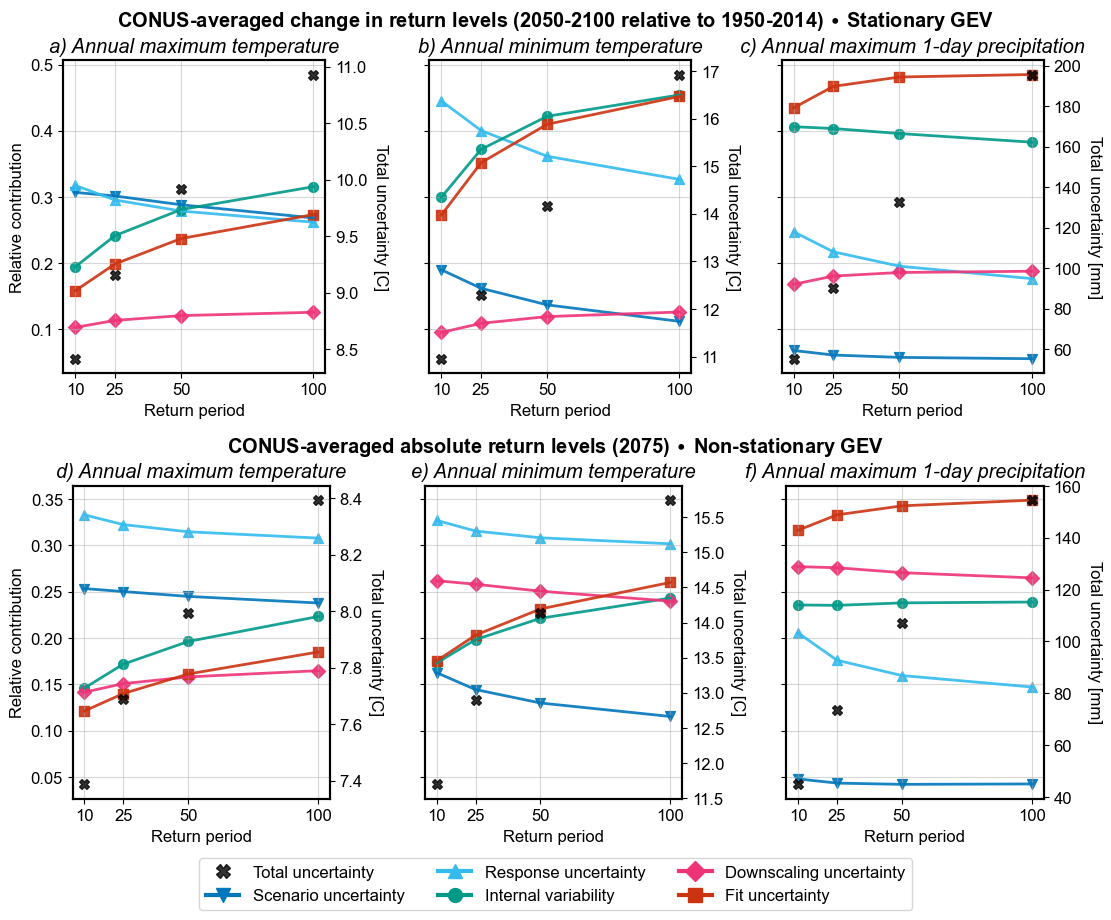

In [9]:
## Main: figure 5
grid = 'LOCA2'
regrid_method = 'nearest'
return_periods = [10,25,50,100]
total_uc = 'uc_99w_main'
# total_uc = 'uc_range_main'

## Stationary: change
proj_slice = '2050-2100'
fit_method = 'lmom'
stat_str = 'stat'

fig = plt.figure(layout='constrained', figsize=(11, 9))
subfigs = fig.subfigures(3, 1, hspace=0.12, height_ratios=[8,8,1])

# Top tow: change from historical
hist_slice = '1950-2014'
axsTop = subfigs[0].subplots(1, 3, sharey=True, gridspec_kw={"wspace": 0.1})

pu.plot_uc_rls(
    coord_or_mean="mean",
    proj_slice=proj_slice,
    hist_slice=hist_slice,
    fit_method=fit_method,
    stat_str=stat_str,
    grid=grid,
    total_uc=total_uc,
    regrid_method=regrid_method,
    title = "CONUS-averaged change in return levels (2050-2100 relative to 1950-2014)" + r" $\bullet$ " + "Stationary GEV",
    fig = subfigs[0], 
    axs = axsTop,
    store_path = None,
    legend = False,
    y_title = 1.06,
    time_str = 'diff',
)

## Non-stationary: absolute
proj_slice = '1950-2100'
fit_method = 'mle'
stat_str = 'nonstat'

axsBottom = subfigs[1].subplots(1, 3, sharey=True, gridspec_kw={"wspace": 0.1})

legend_elements = pu.plot_uc_rls(
    coord_or_mean="mean",
    proj_slice=proj_slice,
    hist_slice=hist_slice,
    fit_method=fit_method,
    stat_str=stat_str,
    grid=grid,
    total_uc=total_uc,
    regrid_method=regrid_method,
    title = "CONUS-averaged absolute return levels (2075)" + r" $\bullet$ " + "Non-stationary GEV",
    fig = subfigs[1], 
    axs = axsBottom,
    store_path = None,
    legend=False,
    idm_start=3,
    return_legend=True,
    y_title = 1.06,
    time_str = '2075',
    plot_fit_uc = True
)

# Add legend
subfigs[2].legend(handles=legend_elements,
                  bbox_to_anchor=[0.5, 1.0],
                  loc='center',
                  fontsize=12,
                  ncol=3)

plt.savefig('../figs/main/final/figure5.pdf', bbox_inches='tight')

### Maps

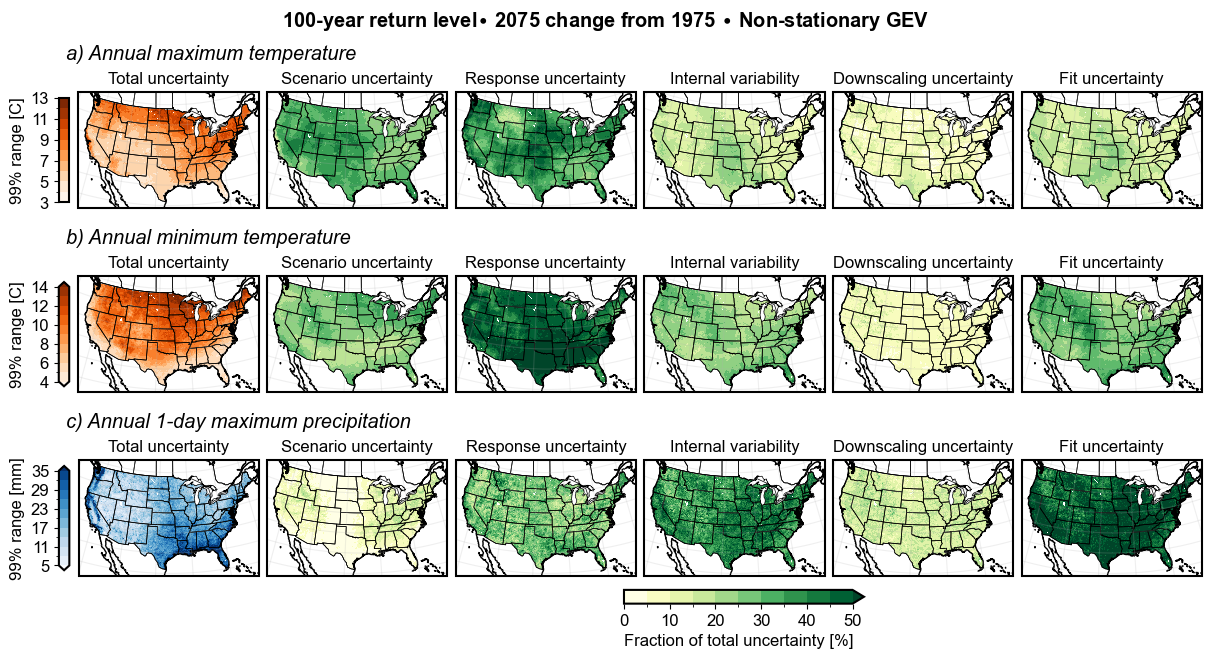

In [6]:
# Main plot
proj_slice = '1950-2100'
hist_slice = None
stationary = False
col_name = '2075-1975'
return_period = 100
fit_method = 'mle'
stat_str = "nonstat"
grid = 'LOCA2'
norm = 'uc_99w_main'
regrid_method = "nearest"
time_str ='diff_2075-1975'

fig = plt.figure(figsize=(12, 5.5), layout='constrained')
subfigs = fig.subfigures(3, 1, hspace=0.01)

fig.suptitle("100-year return level" + r"$\bullet$" + " 2075 change from 1975 " + r"$\bullet$" + " Non-stationary GEV", fontweight="bold", y=1.09)

plot_metric_ids = ['max_tasmax', 'min_tasmin', 'max_pr']

# Loop through metrics
for idp, metric_id in enumerate(plot_metric_ids):
    axs = subfigs[idp].subplots(1, 6, subplot_kw=dict(projection=ccrs.LambertConformal()))
    p = pu.plot_uc_map(
        metric_id=metric_id,
        proj_slice=proj_slice,
        hist_slice=hist_slice,
        plot_col=f"{return_period}yr_return_level",
        return_period=return_period,
        grid=grid,
        fit_method=fit_method,
        stationary=stationary,
        time_str = time_str,
        norm=norm,
        analysis_type="extreme_value",
        vmax_uc = 50,
        y_title = 1.08,
        title = pu.subfigure_labels[idp],
        fig=subfigs[idp],
        axs=axs,
        plot_fit_uc=True,
    )

# Create a new axes for the colorbar at the bottom
cbar_ax = fig.add_axes([0.515, 0.01, 0.2, 0.025])  # [left, bottom, width, height]

# Add colorbar using the stored mappable
cbar = fig.colorbar(p, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Fraction of total uncertainty [%]')
    
plt.savefig('../figs/si/100yr_rl_nonstat_change.png', dpi=300, bbox_inches='tight')
# plt.show()

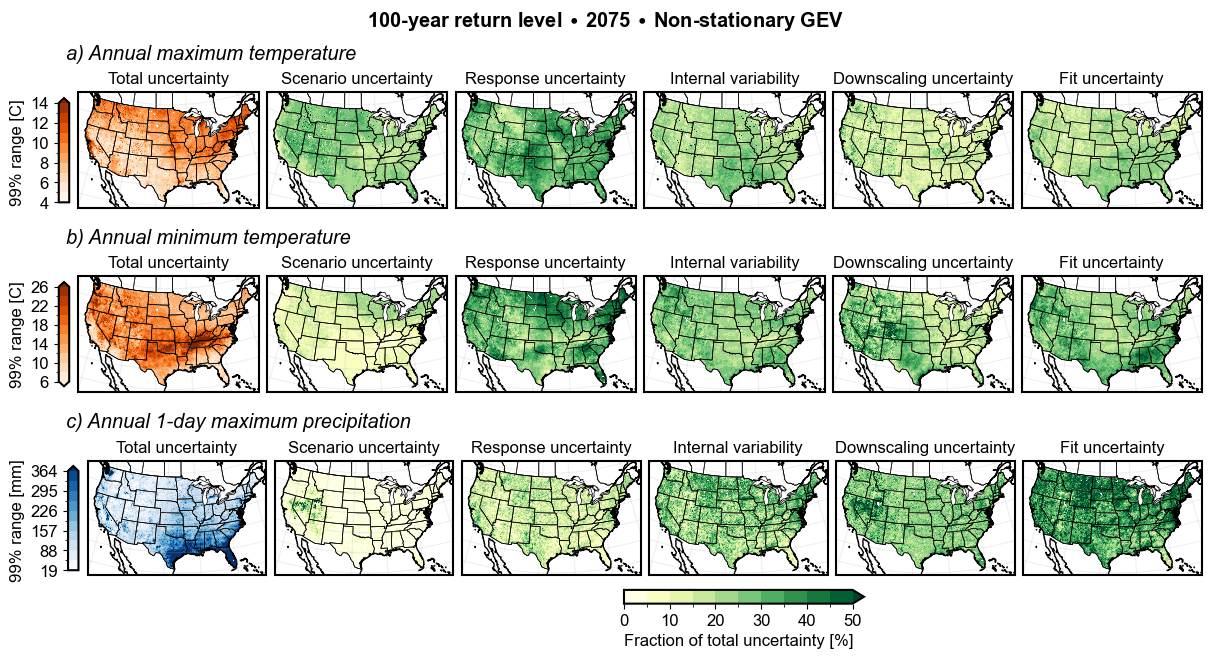

In [7]:
# Non-stationary absolute projection
proj_slice = '1950-2100'
hist_slice = None
stationary = False
col_name = '2075'
return_period = 100
time_str = '2075'
fit_method = 'mle'
stat_str = "nonstat"
grid = 'LOCA2'
norm = 'uc_99w_main'
regrid_method = "nearest"

fig = plt.figure(figsize=(12, 5.5), layout='constrained')
subfigs = fig.subfigures(3, 1, hspace=0.01)

fig.suptitle("100-year return level " + r"$\bullet$" + " 2075 " + r"$\bullet$" + " Non-stationary GEV", fontweight="bold", y=1.09)

plot_metric_ids = ['max_tasmax', 'min_tasmin', 'max_pr']

# Loop through metrics
for idp, metric_id in enumerate(plot_metric_ids):
    axs = subfigs[idp].subplots(1, 6, subplot_kw=dict(projection=ccrs.LambertConformal()))
    p = pu.plot_uc_map(
        metric_id=metric_id,
        proj_slice=proj_slice,
        hist_slice=hist_slice,
        plot_col=f"{return_period}yr_return_level",
        return_period=return_period,
        grid=grid,
        fit_method=fit_method,
        stationary=stationary,
        time_str=time_str,
        norm=norm,
        analysis_type="extreme_value",
        vmax_uc = 50,
        y_title = 1.08,
        title = pu.subfigure_labels[idp],
        fig=subfigs[idp],
        axs=axs,
        plot_fit_uc=True,
    )

# Create a new axes for the colorbar at the bottom
cbar_ax = fig.add_axes([0.515, 0.01, 0.2, 0.025])  # [left, bottom, width, height]

# Add colorbar using the stored mappable
cbar = fig.colorbar(p, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Fraction of total uncertainty [%]')
    
plt.savefig('../figs/main/figure4.png', dpi=300, bbox_inches='tight')

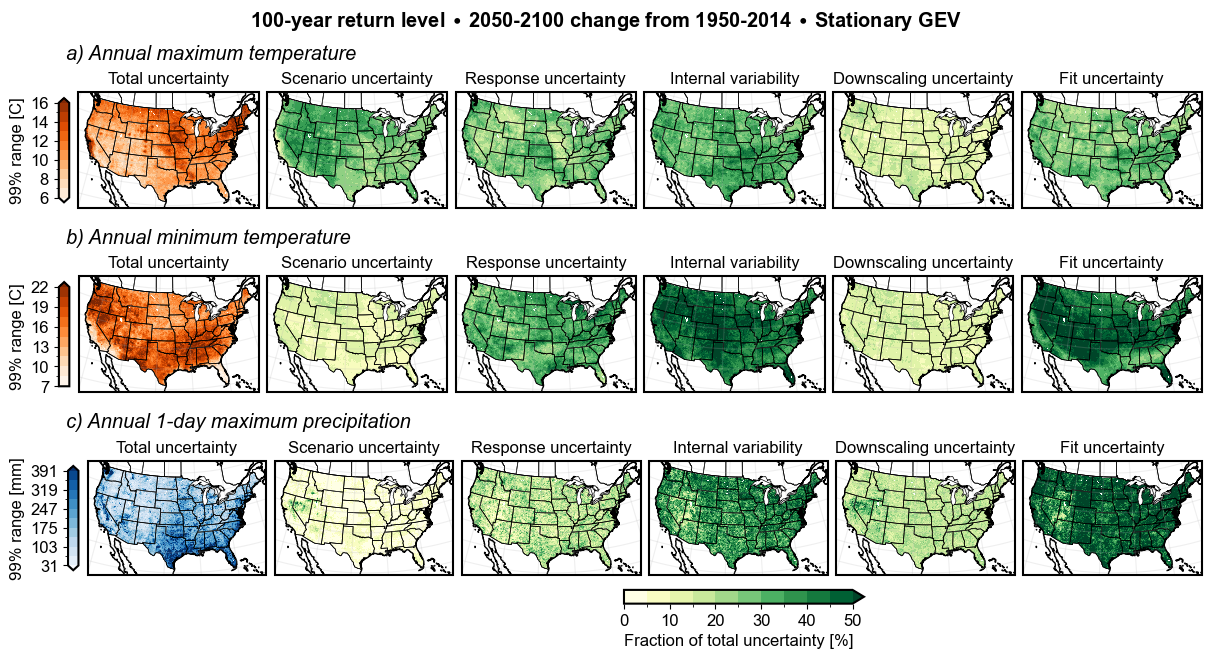

In [17]:
# Main plot
proj_slice = '2050-2100'
hist_slice = '1950-2014'
stationary = True
return_period = 100
fit_method = 'lmom'
stat_str = "stat"
time_str = 'diff'
grid = 'LOCA2'
regrid_method = "nearest"
norm = 'uc_99w_main'

fig = plt.figure(figsize=(12, 5.5), layout='constrained')
subfigs = fig.subfigures(3, 1, hspace=0.01)

fig.suptitle("100-year return level " + r"$\bullet$" + " 2050-2100 change from 1950-2014 " + r"$\bullet$" + " Stationary GEV", fontweight="bold", y=1.09)

# Loop through metrics
for idp, metric_id in enumerate(gev_metric_ids[:-2]):
    axs = subfigs[idp].subplots(1, 6, subplot_kw=dict(projection=ccrs.LambertConformal()))
    p = pu.plot_uc_map(
        metric_id=metric_id,
        proj_slice=proj_slice,
        hist_slice=hist_slice,
        plot_col=f"{return_period}yr_return_level",
        return_period=return_period,
        grid=grid,
        fit_method=fit_method,
        stationary=stationary,
        time_str=time_str,
        norm=norm,
        analysis_type="extreme_value",
        vmax_uc = 50,
        y_title = 1.08,
        title = pu.subfigure_labels[idp],
        fig=subfigs[idp],
        axs=axs,
        plot_fit_uc=True,
    )

# Create a new axes for the colorbar at the bottom
cbar_ax = fig.add_axes([0.515, 0.01, 0.2, 0.025])  # [left, bottom, width, height]

# Add colorbar using the stored mappable
cbar = fig.colorbar(p, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Fraction of total uncertainty [%]')
    
plt.savefig('../figs/main/figure3.png', dpi=300, bbox_inches='tight')

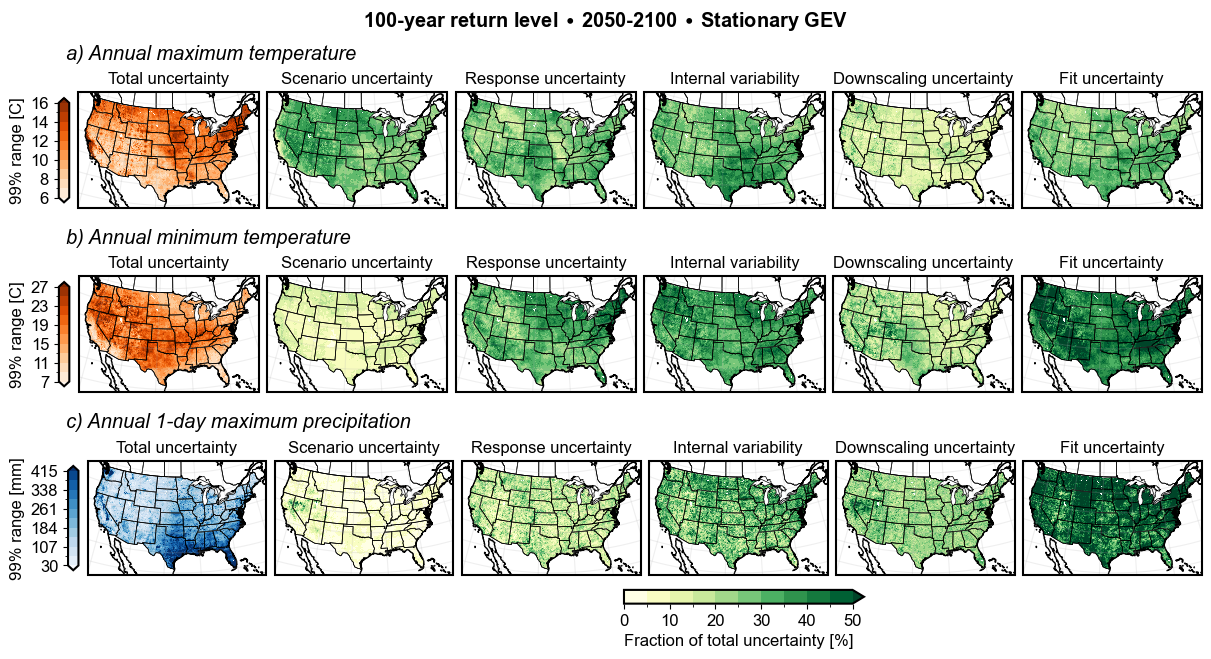

In [17]:
# Main plot
proj_slice = '2050-2100'
stationary = True
hist_slice = None
return_period = 100
fit_method = 'lmom'
stat_str = "stat"
time_str = 'proj'
grid = 'LOCA2'
norm = 'uc_99w_main'

fig = plt.figure(figsize=(12, 5.5), layout='constrained')
subfigs = fig.subfigures(3, 1, hspace=0.01)

fig.suptitle("100-year return level " + r"$\bullet$" + " 2050-2100 " + r"$\bullet$" + " Stationary GEV", fontweight="bold", y=1.09)

# Loop through metrics
for idp, metric_id in enumerate(gev_metric_ids[:-2]):
    axs = subfigs[idp].subplots(1, 6, subplot_kw=dict(projection=ccrs.LambertConformal()))
    p = pu.plot_uc_map(
        metric_id=metric_id,
        proj_slice=proj_slice,
        hist_slice=hist_slice,
        plot_col=f"{return_period}yr_return_level",
        return_period=return_period,
        grid=grid,
        fit_method=fit_method,
        time_str = time_str,
        stationary=stationary,
        norm=norm,
        analysis_type="extreme_value",
        vmax_uc = 50,
        y_title = 1.08,
        title = pu.subfigure_labels[idp],
        fig=subfigs[idp],
        axs=axs,
        plot_fit_uc=True,
    )

# Create a new axes for the colorbar at the bottom
cbar_ax = fig.add_axes([0.515, 0.01, 0.2, 0.025])  # [left, bottom, width, height]

# Add colorbar using the stored mappable
cbar = fig.colorbar(p, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Fraction of total uncertainty [%]')
    
plt.savefig('../figs/si/100yr_rl_stat_abs.png', dpi=300, bbox_inches='tight')